<a href="https://colab.research.google.com/github/AlexandreMinato/Investimentos_FII/blob/main/Analises_FII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install pandas numpy matplotlib lxml html5lib beautifulsoup4

In [3]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime


# Capturando informacões
Capturando as informações do fundsexplorer para iniciar a analise. São 2 etapas:

1.   Informações gerais dos fundos imobiliarios
2.   Informações sobre pagamentos de variação de dividendos, oscilação, minimo, maximo e etc

O objetivo desta analise é encontrar fundos que pague dividendos sem muita oscilação, fundos com diversificação em seus ativos, que tenha liquidez e que tenha um valor justo (cota x valor patrimonial) adequado para compra

## 1) Informações gerais dos fundos imobiliarios - capturando informações

In [13]:
url = 'https://www.fundsexplorer.com.br/ranking'
dados = requests.get(url,  headers={'User-Agent': 'Mozilla/5.0'})
list_obj = pd.read_html(dados.text, attrs={'id': 'table-ranking'})
df = list_obj[0]

In [14]:
# redefinindo nome das colunas
df.columns = ['ativo',
              'setor',
              'preco',
              'liquidez_dia',
              'dividendo',
              'yield',
              'yield_3m_acululado',
              'yield_6m_acululado',
              'yield_12m_acululado',
              'yield_3m_media',
              'yield_6m_media',
              'yield_12m_media',
              'yield_ano',
              'variacao_preco',
              'rent_periodo',
              'rent_acumulada',
              'patrimonio_liq',
              'vpa',
              'p_vpa',
              'dy_patrimonial',
              'variacao_patrimonial',
              'rent_patr_periodo',
              'rent_acumulada_periodo',
              'vacancia_fisica',
              'vacancia_financeira',
              'quantidade_ativos']

In [15]:
df.head()

,ativo,setor,preco,liquidez_dia,dividendo,yield,yield_3m_acululado,yield_6m_acululado,yield_12m_acululado,yield_3m_media,...,patrimonio_liq,vpa,p_vpa,dy_patrimonial,variacao_patrimonial,rent_patr_periodo,rent_acumulada_periodo,vacancia_fisica,vacancia_financeira,quantidade_ativos
0,FIVN11,Shoppings,"R$ 2,41",783.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 64.638.528,46","R$ 6,87",35.0,NaN,NaN,NaN,NaN,"56,00%",NaN,1
1,BZLI11,Títulos e Val. Mob.,"R$ 14,70",44041.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 432.053.734,70","R$ 11,04",133.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,XTED11,Lajes Corporativas,"R$ 6,78",694.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 26.247.801,80","R$ 13,59",50.0,NaN,NaN,NaN,NaN,"0,00%","100,00%",1
3,ALMI11,Lajes Corporativas,"R$ 1.000,09",49.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 228.954.055,08","R$ 2.059,37",49.0,NaN,NaN,NaN,NaN,"68,15%",NaN,1
4,DOMC11,Lajes Corporativas,"R$ 439,00",42.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 271.098.110,28","R$ 110,93",396.0,NaN,NaN,NaN,NaN,"23,44%",NaN,1


### Normalizando as colunas

In [16]:
def identificar_conteudo_colunas(df, item):
    
    return [df[column].name for column in df if df[column].astype(str).str.contains(item).any()]

In [17]:
#Converter financeiro
coluna_monetario = identificar_conteudo_colunas(df, '\$')

for column_name in coluna_monetario:
    df[column_name] = df[column_name].str.replace('.', '', regex=False)
    df[column_name] = df[column_name].str.replace(',', '.', regex=False)
    df[column_name] = df[column_name].str.replace(r'[R\$ ,]', '', regex=True).astype(float)

In [18]:
# Converter as colunas de percentual em numericas
coluna_percentual = identificar_conteudo_colunas(df, '\%')
for column_name in coluna_percentual:
    df[column_name] = df[column_name].str.replace('.', '')
    df[column_name] = df[column_name].str.replace(',', '.')
    df[column_name] = df[column_name].str.replace(r'[%,]', '', regex=True).astype(float)
    df[column_name] = df[column_name]/100

<ipython-input-18-9b959c9bd26b>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '')


In [19]:
# Normaliza o setor
df['setor'] = df['setor'].str.replace(r'\s+', '_', regex=True)
df['setor'] = df['setor'].str.replace(r'[^\w\s]+', '_', regex=True)
df['setor'] = df['setor'].str.lower()
df['setor'] = df['setor'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

## Iniciando as analises


In [20]:
df.setor.unique()

array(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas',
       'hibrido', 'hotel', 'outros', 'residencial', 'hospital',
       'logistica'], dtype=object)

In [21]:
df.ativo.nunique()

249

In [22]:
# Corrigindo o valor patrimonial por acao
df['p_vpa'] = df['p_vpa']/100

In [23]:
df.describe()

,preco,liquidez_dia,dividendo,yield,yield_3m_acululado,yield_6m_acululado,yield_12m_acululado,yield_3m_media,yield_6m_media,yield_12m_media,...,patrimonio_liq,vpa,p_vpa,dy_patrimonial,variacao_patrimonial,rent_patr_periodo,rent_acumulada_periodo,vacancia_fisica,vacancia_financeira,quantidade_ativos
count,243.000000,243.000000,250.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,...,2.500000e+02,250.000000,243.000000,219.000000,219.000000,219.000000,219.000000,120.000000,27.000000,250.000000
mean,436.844362,15055.987654,1.163520,0.008331,0.020775,0.036576,0.056584,0.006927,0.006095,0.004714,...,5.317172e+08,484.310760,0.879177,0.006855,-0.006091,0.000710,0.242611,0.154957,0.109756,3.432000
std,4738.336978,44979.931052,2.941909,0.023335,0.025212,0.031625,0.052615,0.008402,0.005272,0.004385,...,7.503034e+08,4927.474492,0.315119,0.002919,0.027294,0.027291,3.394580,0.231546,0.207843,8.036899
min,0.600000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-7.370514e+06,-9.720000,-1.220000,0.001000,-0.190600,-0.182700,-0.989300,0.000000,0.000000,0.000000
25%,72.240000,195.000000,0.472500,0.005600,0.015625,0.023975,0.000000,0.005200,0.004025,0.000000,...,1.059315e+08,90.642500,0.790000,0.005250,-0.008550,-0.001550,0.006750,0.000000,0.000000,0.000000
50%,91.520000,2146.000000,0.650000,0.007200,0.020500,0.037600,0.064250,0.006800,0.006300,0.005350,...,2.582186e+08,98.825000,0.890000,0.006500,-0.000800,0.004400,0.022500,0.053000,0.021000,1.000000
75%,103.610000,10916.000000,0.900000,0.008500,0.025275,0.047950,0.085575,0.008400,0.008000,0.007100,...,6.045632e+08,109.632500,0.990000,0.008400,0.000400,0.006900,0.042700,0.183050,0.116400,3.000000
max,73900.000000,524818.000000,29.050000,0.363200,0.379900,0.409600,0.452200,0.126600,0.068300,0.037700,...,5.860326e+09,77824.110000,3.960000,0.021700,0.290600,0.299400,50.223100,1.000000,1.000000,72.000000


In [24]:
df.setor.unique()

array(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas',
       'hibrido', 'hotel', 'outros', 'residencial', 'hospital',
       'logistica'], dtype=object)

In [25]:
# filtrando setores que eu gosto
df = df[df['setor'] \
        .isin(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas', 'hibrido', 'logistica'])].copy()

In [26]:
df.setor.unique()

array(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas',
       'hibrido', 'logistica'], dtype=object)

### Condicoes para filtrar os FIIs

In [27]:
#Preco aceitavel para pagamento, considerando cota e valor patrimonial
df['preco_justo'] = np.where((df['p_vpa'] > 0.9) & (df['p_vpa'] < 1.1) , True, False)

setores_considerar = ['shoppings', 'lajes_corporativas', 'logistica']

# Criando filtros
diversificacoes_ativos = [
    # Condicoes de setores que gosto com mais de 5 ativos
    (df['setor'].isin(setores_considerar)) & 
    (df['quantidade_ativos'] > 5),
    # Condicoes de setores que gosto com menos de 5 ativos 
    # (inativo na hora de aplicar o filtro, deixei aqui, 
    # caso queira olhar para fundos com pouca diversificação,
    # bastante alterar a variavel diversificacoes_aceitaveis para True, True, True)
    (df['setor'].isin(setores_considerar)) &
    (df['quantidade_ativos'] < 5),
    # setores
    (~df['setor'].isin(setores_considerar))
]
#Aplicacao dos filtros
diversificacoes_aceitaveis = [True, False, True]
df['ativos_diversificados'] = np.select(diversificacoes_ativos, diversificacoes_aceitaveis, default=None)

# imovel com vacancia aceitavel
df['vacancia_aceitavel'] = np.where((df['vacancia_fisica'] < 0.1) | \
                                    (df['vacancia_fisica'].isnull()) | \
                                    (df['vacancia_fisica'].isnull()) , True, False)

# Fundo que tenham liquidez
df['liquidez'] = np.where(df['liquidez_dia'] > 20000, True, False)

# Fundos que pagam dividendos acima de 0,5%, considerando o acumulado de 12 meses
df['dividendos_minimos'] = np.where(df['yield_12m_acululado'] > 0.05, True, False)

### Criando as condições dos filtros

In [28]:
condicoes_ativos = (
    df.preco_justo &
    df.ativos_diversificados &
    df.vacancia_aceitavel &
    df.liquidez &
    df.dividendos_minimos
)
df_results = df.loc[condicoes_ativos].sort_values(by=['yield_12m_acululado', 'liquidez_dia'], ascending=False)
df_results = df_results.set_index('ativo')

# Analisando os resultados
*Os papéis abaixo atendem aos filtros de diversificação e preço justo.

In [29]:
df_results

,setor,preco,liquidez_dia,dividendo,yield,yield_3m_acululado,yield_6m_acululado,yield_12m_acululado,yield_3m_media,yield_6m_media,...,rent_patr_periodo,rent_acumulada_periodo,vacancia_fisica,vacancia_financeira,quantidade_ativos,preco_justo,ativos_diversificados,vacancia_aceitavel,liquidez,dividendos_minimos
ativo,,,,,,,,,,,,,,,,,,,,,
RECR11,titulos_e_val__mob_,99.88,176044.0,1.09,0.0107,0.0314,0.0646,0.1348,0.0105,0.0108,...,0.0095,0.0931,NaN,NaN,0,True,True,True,True,True
CVBI11,titulos_e_val__mob_,102.10,23306.0,1.23,0.0120,0.0300,0.0585,0.1323,0.0100,0.0098,...,0.0098,0.0857,NaN,NaN,0,True,True,True,True,True
KNHY11,titulos_e_val__mob_,105.15,29579.0,1.07,0.0100,0.0331,0.0632,0.1241,0.0110,0.0105,...,0.0003,0.0158,NaN,NaN,0,True,True,True,True,True
KNIP11,titulos_e_val__mob_,103.12,53176.0,1.20,0.0115,0.0327,0.0622,0.1199,0.0109,0.0104,...,-0.0051,0.0080,NaN,NaN,0,True,True,True,True,True
CPTS11,titulos_e_val__mob_,98.81,76359.0,1.00,0.0101,0.0301,0.0601,0.1178,0.0100,0.0100,...,0.0057,0.0475,NaN,NaN,0,True,True,True,True,True
BBPO11,lajes_corporativas,93.48,26503.0,0.82,0.0084,0.0249,0.0530,0.1057,0.0083,0.0088,...,0.0041,0.0225,0.0000,0.0000,64,True,True,True,True,True
VINO11,lajes_corporativas,60.05,31827.0,0.65,0.0107,0.0281,0.0506,0.0905,0.0094,0.0084,...,0.0025,0.0308,0.0070,NaN,9,True,True,True,True,True
MCCI11,titulos_e_val__mob_,101.85,35909.0,1.00,0.0097,0.0293,0.0517,0.0886,0.0098,0.0086,...,0.0120,0.0199,NaN,NaN,0,True,True,True,True,True
HGCR11,titulos_e_val__mob_,103.92,20502.0,0.85,0.0079,0.0232,0.0506,0.0864,0.0077,0.0084,...,0.0047,0.0326,NaN,NaN,0,True,True,True,True,True


## Simulando valor de investimento para calcular o retorno (forecast)

In [64]:
df_results.columns

Index(['setor', 'preco', 'liquidez_dia', 'dividendo', 'yield',
       'yield_3m_acululado', 'yield_6m_acululado', 'yield_12m_acululado',
       'yield_3m_media', 'yield_6m_media', 'yield_12m_media', 'yield_ano',
       'variacao_preco', 'rent_periodo', 'rent_acumulada', 'patrimonio_liq',
       'vpa', 'p_vpa', 'dy_patrimonial', 'variacao_patrimonial',
       'rent_patr_periodo', 'rent_acumulada_periodo', 'vacancia_fisica',
       'vacancia_financeira', 'quantidade_ativos', 'preco_justo',
       'ativos_diversificados', 'vacancia_aceitavel', 'liquidez',
       'dividendos_minimos', 'valor_investir', 'resultado_previsto',
       'qtd_cotas_por_valor_investido'],
      dtype='object')

In [67]:
valor_investir = 1000
df_results['qtd_cotas_por_valor_investido'] = (valor_investir / df_results.preco)
df_results['qtd_cotas_por_valor_investido'] = df_results['qtd_cotas_por_valor_investido'].astype(int)
df_results['resultado_previsto'] = df_results['qtd_cotas_por_valor_investido'] \
                                        .astype(int) * df_results['dividendo'].astype(float)
df_results[['setor', 'p_vpa', 'preco', 'dividendo', 
            'yield', 'yield_12m_acululado',
            'qtd_cotas_por_valor_investido', 'resultado_previsto']]

,setor,p_vpa,preco,dividendo,yield,yield_12m_acululado,qtd_cotas_por_valor_investido,resultado_previsto
ativo,,,,,,,,
RECR11,titulos_e_val__mob_,1.05,99.88,1.09,0.0107,0.1348,10,10.90
CVBI11,titulos_e_val__mob_,1.02,102.10,1.23,0.0120,0.1323,9,11.07
KNHY11,titulos_e_val__mob_,1.06,105.15,1.07,0.0100,0.1241,9,9.63
KNIP11,titulos_e_val__mob_,1.04,103.12,1.20,0.0115,0.1199,9,10.80
CPTS11,titulos_e_val__mob_,1.04,98.81,1.00,0.0101,0.1178,10,10.00
BBPO11,lajes_corporativas,0.98,93.48,0.82,0.0084,0.1057,10,8.20
VINO11,lajes_corporativas,1.01,60.05,0.65,0.0107,0.0905,16,10.40
MCCI11,titulos_e_val__mob_,1.01,101.85,1.00,0.0097,0.0886,9,9.00
HGCR11,titulos_e_val__mob_,1.01,103.92,0.85,0.0079,0.0864,9,7.65


<BarContainer object of 18 artists>

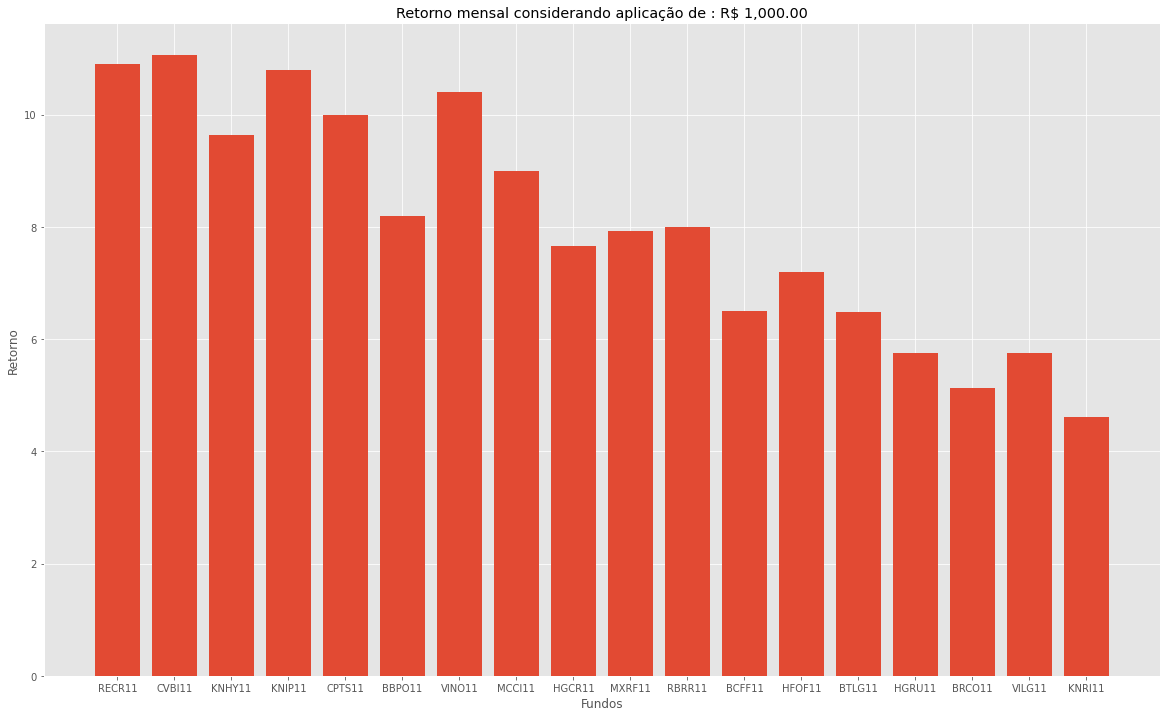

In [48]:
titulo = 'Retorno mensal considerando aplicação de : ' + "R$ {:,.2f}". format(valor_investir)
plt.style.use("ggplot")
plt.figure(figsize = (20, 12))
plt.title(titulo)
plt.xlabel("Fundos")
plt.ylabel("Retorno")
plt.bar(df_results.index, df_results.resultado_previsto)

# Etapa 2: consulta de pagamento dos dividendos mensais de cada fundo

In [49]:
def capturar_valor_rendimentos(codFII):
    url_rend = 'https://fiis.com.br/' + codFII
    dados_rend = requests.get(url_rend,  headers={'User-Agent': 'Mozilla/5.0'})
    tb_rend = pd.read_html(dados_rend.text, attrs={'id': 'last-revenues--table'})
    df_rend = tb_rend[0]  
    df_rend.columns = ['data_base', 'data_pagamento', 'cotacao_base', 'div_yield', 'rendimento']
    df_rend.insert(0,'ativo', codFII)
    df_rend.set_index('ativo')

    coluna_monetario = identificar_conteudo_colunas(df_rend, '\$')
    for column_name in coluna_monetario:
        df_rend[column_name] = df_rend[column_name].str.replace('.', '', regex=False)
        df_rend[column_name] = df_rend[column_name].str.replace(',', '.', regex=False)
        df_rend[column_name] = df_rend[column_name].str.replace(r'[R\$ ,]', '', regex=True).astype(float)

    coluna_percentual = identificar_conteudo_colunas(df_rend, '\%')
    for column_name in coluna_percentual:
        df_rend[column_name] = df_rend[column_name].str.replace(',', '.', regex=False)
        df_rend[column_name] = df_rend[column_name].str.replace(r'[%,]', '', regex=True).astype(float)
        df_rend[column_name] = df_rend[column_name]/100

    #Converter colunas de datas
    coluna_data = identificar_conteudo_colunas(df_rend, '\/')
    for column_name in coluna_data:
        df_rend[column_name] = df_rend[column_name].apply(lambda x: datetime.strptime(x, '%d/%m/%y'))
      
    df_result = df_rend.groupby('ativo').agg({'rendimento': ['min','max', 'median', 'var', 'mean', 'quantile']})
    df_result.columns = ['minimo','maximo', 'mediana', 'variacao', 'media', 'quartil']
    return df_result

In [56]:
df_union

,minimo,maximo,mediana,variacao,media,quartil
RECR11,1.00,1.67,1.100,0.043329,1.188,1.100
CVBI11,0.85,1.95,1.000,0.103404,1.136,1.000
KNHY11,1.07,1.42,1.200,0.012757,1.203,1.200
KNIP11,1.00,1.35,1.165,0.011801,1.157,1.165
CPTS11,1.00,1.05,1.010,0.000596,1.022,1.010
BBPO11,0.82,1.08,1.080,0.012018,1.028,1.080
VINO11,0.42,0.65,0.450,0.005366,0.481,0.450
MCCI11,0.60,1.00,0.700,0.027667,0.790,0.700
HGCR11,0.62,1.45,0.740,0.057551,0.802,0.740
MXRF11,0.07,0.08,0.080,0.000027,0.076,0.080


In [50]:
df_union = pd.DataFrame(columns=['minimo','maximo', 'mediana', 'variacao', 'media', 'quartil']) 

for ind in df_results.index:
    df_union = df_union.append([capturar_valor_rendimentos(ind)])

In [51]:
df_union_data = pd.concat([df_union, df_results], axis=1)

# Cruzando informacoes gerais do fundo (vacancia, liquidez e etc) com rendimentos pagos (minimo, maximo, desvio padrao e etc)

In [52]:
df_union_data

,minimo,maximo,mediana,variacao,media,quartil,setor,preco,liquidez_dia,dividendo,...,vacancia_financeira,quantidade_ativos,preco_justo,ativos_diversificados,vacancia_aceitavel,liquidez,dividendos_minimos,valor_investir,resultado_previsto,qtd_cotas_por_valor_investido
RECR11,1.00,1.67,1.100,0.043329,1.188,1.100,titulos_e_val__mob_,99.88,176044.0,1.09,...,NaN,0,True,True,True,True,True,10,10.90,10
CVBI11,0.85,1.95,1.000,0.103404,1.136,1.000,titulos_e_val__mob_,102.10,23306.0,1.23,...,NaN,0,True,True,True,True,True,9,11.07,9
KNHY11,1.07,1.42,1.200,0.012757,1.203,1.200,titulos_e_val__mob_,105.15,29579.0,1.07,...,NaN,0,True,True,True,True,True,9,9.63,9
KNIP11,1.00,1.35,1.165,0.011801,1.157,1.165,titulos_e_val__mob_,103.12,53176.0,1.20,...,NaN,0,True,True,True,True,True,9,10.80,9
CPTS11,1.00,1.05,1.010,0.000596,1.022,1.010,titulos_e_val__mob_,98.81,76359.0,1.00,...,NaN,0,True,True,True,True,True,10,10.00,10
BBPO11,0.82,1.08,1.080,0.012018,1.028,1.080,lajes_corporativas,93.48,26503.0,0.82,...,0.0000,64,True,True,True,True,True,10,8.20,10
VINO11,0.42,0.65,0.450,0.005366,0.481,0.450,lajes_corporativas,60.05,31827.0,0.65,...,NaN,9,True,True,True,True,True,16,10.40,16
MCCI11,0.60,1.00,0.700,0.027667,0.790,0.700,titulos_e_val__mob_,101.85,35909.0,1.00,...,NaN,0,True,True,True,True,True,9,9.00,9
HGCR11,0.62,1.45,0.740,0.057551,0.802,0.740,titulos_e_val__mob_,103.92,20502.0,0.85,...,NaN,0,True,True,True,True,True,9,7.65,9
MXRF11,0.07,0.08,0.080,0.000027,0.076,0.080,hibrido,10.01,524818.0,0.08,...,NaN,0,True,True,True,True,True,99,7.92,99


<AxesSubplot:>

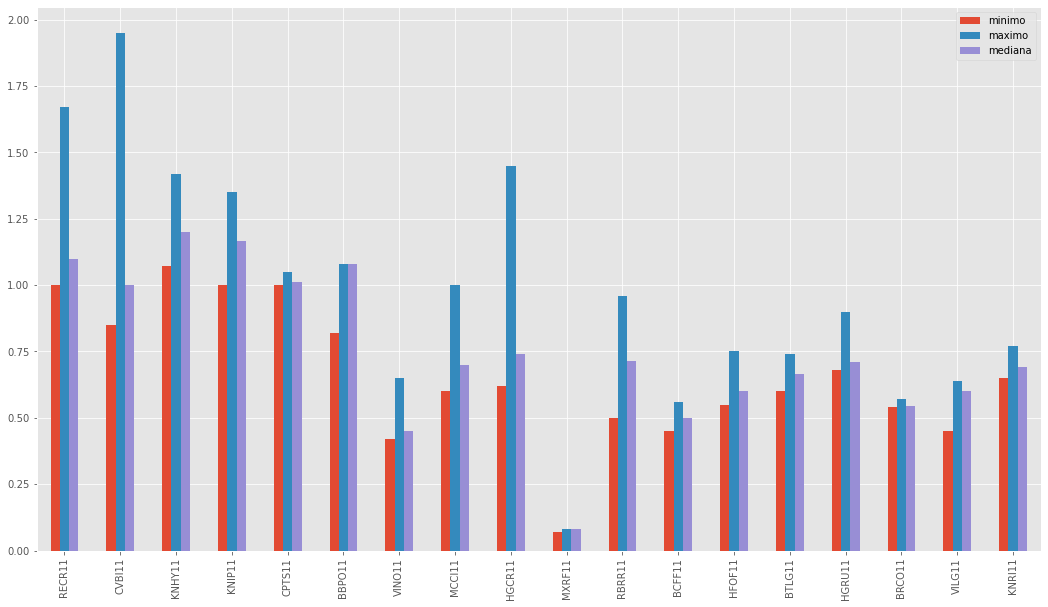

In [53]:
plt.style.use('ggplot')
df_union_data[['minimo', 'maximo', 'mediana']].plot(figsize = (18, 10), grid=True, kind='bar')

<AxesSubplot:>

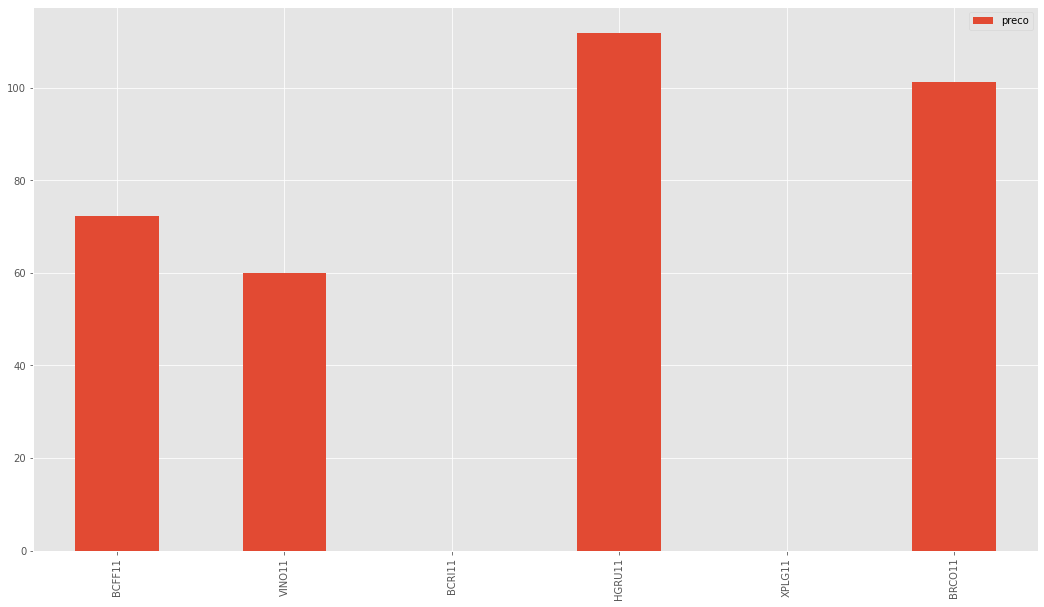

In [54]:
df_union_data[['preco']] \
    .reindex(['BCFF11', 'VINO11', 'BCRI11', 'HGRU11', 'XPLG11', 'BRCO11']) \
    .plot(figsize = (18, 10), grid=True, kind='bar')

In [55]:
df_results[['preco', 'dividendo', 'yield', 'resultado_previsto']] \
    .reindex(['BCFF11', 'VINO11', 'BCRI11', 'HGRU11', 'XPLG11', 'BRCO11']) \
    .sort_values(by=['yield'], ascending=False)

,preco,dividendo,yield,resultado_previsto
ativo,,,,
VINO11,60.05,0.65,0.0107,10.40
BCFF11,72.40,0.50,0.0069,6.50
HGRU11,111.89,0.72,0.0064,5.76
BRCO11,101.19,0.57,0.0058,5.13
BCRI11,NaN,NaN,NaN,NaN
XPLG11,NaN,NaN,NaN,NaN
